# Setting up a Scalable ML Data Pipeline

As we have seen, in deep learning we often deal with large datasets, which might even exceed the memory available to us.  

In this lab you will learn how to set up a more scalable data pipeline where the data stays on disk until is needed during training.

Here is the code to download the Intel Image Classification dataset.

In [1]:
import os
if not os.path.exists('seg_train'):
  !wget -O archive.zip https://www.dropbox.com/scl/fi/ribf92om67kpi34wukl7q/archive.zip?rlkey=qn5v9cwvaqwba8jhsr7diyxnm&dl=1
  !unzip -qq archive.zip

unzip:  cannot find or open archive.zip, archive.zip.zip or archive.zip.ZIP.


In [2]:
import numpy as np
import keras
from matplotlib import pyplot as plt

We will use the Keras function `image_dataset_from_directory` to load the images.  It expects the images to be stored in separate directories according to their labels:

```
   dog/
       - dog1.jpg
       - dog2.jpg
       - ...
   cat/
       - cat1.jpg
       - cat2.jpg
       - ...
```

It returns a Tensorflow `Dataset` object.  Note that it does not load the images from disk -- it just looks through the directory and catalogs which images are available.

In [3]:
train_ds = keras.preprocessing.image_dataset_from_directory('seg_train/seg_train')
train_ds

Found 14034 files belonging to 6 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [4]:
train_ds.class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

When we iterate over the dataset, it loads batches of images from disk.  The batch size is set by the `batch_size` argument to `image_dataset_from_directory`.

Here `.take(1)` tells the dataset we only want the first batch.

Because the data is returned as `EagerTensor`s, we have to call `.numpy()` for them to be actually loaded and converted to Numpy arrays.

images: (32, 256, 256, 3) <dtype: 'float32'> labels: (32,) <dtype: 'int32'>
image data range: 0.0 255.0


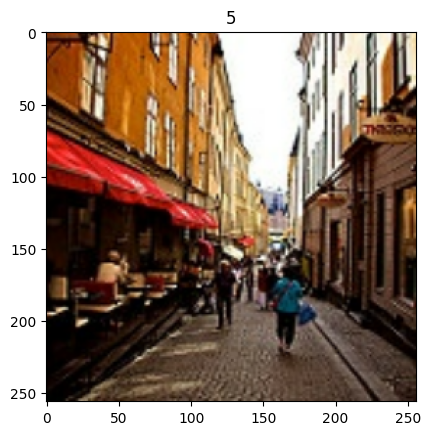

2024-11-04 10:57:46.398209: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
for images, labels in train_ds.take(1):
  print('images:',images.shape,images.dtype,'labels:',labels.shape,labels.dtype)
  print('image data range:',images[0].numpy().min(),images[0].numpy().max())
  plt.imshow(images[0].numpy().astype('uint8'))
  plt.title(labels[0].numpy())
  plt.show()

`image_dataset_from_directory` resizes the images so that they all have the same shape.  You can control the image size through the `image_size` argument.  The default is $256\times256$.

If the original image is not square, then the image will be somewhat squashed by the resize operation.  To avoid this, you can set `crop_to_aspect_ratio=True` so that it will center crop the image before resizing.

`image_dataset_from_directory` can automatically create a validation split for you, using the `validation_split` argument.  You need to call the function twice: once with `subset='train'` and once with `subset='validation'` to make both datasets.  And, you should set the `seed` argument to ensure that the same split is used both times!

In [6]:
train_ds = keras.preprocessing.image_dataset_from_directory(
    'seg_train/seg_train',
    subset='training',
    validation_split=0.1,
    seed=42)

Found 14034 files belonging to 6 classes.
Using 12631 files for training.


In [7]:
val_ds = keras.preprocessing.image_dataset_from_directory(
    'seg_train/seg_train',
    subset='validation',
    validation_split=0.1,
    seed=42)

Found 14034 files belonging to 6 classes.
Using 1403 files for validation.


## Exercises

Try using `image_dataset_from_directory` in your CNN training.

1. First, create the train, val, and test datasets using `image_dataset_from_directory`.

Set the image size to 128x128 with center cropping, and use a validation split of 0.1.


In [4]:
batch_size = 32
img_size = (128, 128)
seed = 42

train_ds = keras.preprocessing.image_dataset_from_directory(
    'archive/seg_train/seg_train',
    validation_split=0.1,
    subset='training',
    seed=seed,
    image_size=img_size,         
    crop_to_aspect_ratio=True,   
    batch_size=batch_size
)

val_ds = keras.preprocessing.image_dataset_from_directory(
    'archive/seg_train/seg_train',
    validation_split=0.1,
    subset='validation',
    seed=seed,
    image_size=img_size,
    crop_to_aspect_ratio=True,
    batch_size=batch_size
)


test_ds = keras.preprocessing.image_dataset_from_directory(
    'archive/seg_test/seg_test',
    shuffle=False,
    image_size=img_size,
    crop_to_aspect_ratio=True,
    batch_size=batch_size
)

Found 14034 files belonging to 6 classes.
Using 12631 files for training.
Found 14034 files belonging to 6 classes.
Using 1403 files for validation.
Found 3000 files belonging to 6 classes.


2. Set up a CNN for image classification.

Here's my suggested architecture:

* Input layer
* 2D convolution, 3x3 kernel, 32 channels, ReLU activation
* Max pooling: 2x2 kernel, stride of 2
* 2D convolution, 3x3 kernel, 64 channels, ReLU activation
* Max pooling: 2x2 kernel, stride of 2
* 2D convolution, 3x3 kernel, 128 channels, ReLU activation
* Max pooling: 2x2 kernel, stride of 2
* 2D convolution, 3x3 kernel, 256 channels, ReLU activation
* Max pooling: 2x2 kernel, stride of 2
* 2D convolution, 3x3 kernel, 512 channels, ReLU activation
* Max pooling: 2x2 kernel, stride of 2
* Flatten
* Dense output layer configured for multi-class classification

However, we are missing something -- the data preprocessing!  Right now the images are on [0 255] range which is not ideal for NN training.

To address this, we can add a `Lambda` layer right after the `Input` layer.  It should look like this:

`Lambda(lambda x:x/128-1)`

The will preprocess the images so to be on [-1 1] range on-the-fly, as the data is processed in the network.

Try it out and see what accuracy you can get!  (I reached 82.6% test accuracy with this one.)

In [5]:
from keras import Sequential
from keras.optimizers import SGD, Adam
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Lambda
from keras.regularizers import L2

model = Sequential([
    Input(shape=(*img_size, 3)),                      
    Lambda(lambda x: x/128.0 - 1.0),                   
    Conv2D(32,  (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2), strides=2),
    Conv2D(64,  (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2), strides=2),
    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2), strides=2),
    Conv2D(256, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2), strides=2),
    Conv2D(512, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2), strides=2), 
    Flatten(),
    Dense(len(train_ds.class_names), activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │        49,158 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,617,734 (6.17 MB)

 Trainable params: 1,617,734 (6.17 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [7]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
)

Epoch 1/15
395/395 ━━━━━━━━━━━━━━━━━━━━ 108s 271ms/step - accuracy: 0.5401 - loss: 1.1676 - val_accuracy: 0.8019 - val_loss: 0.5552
Epoch 2/15
395/395 ━━━━━━━━━━━━━━━━━━━━ 108s 273ms/step - accuracy: 0.7852 - loss: 0.5980 - val_accuracy: 0.8254 - val_loss: 0.5094
Epoch 3/15
395/395 ━━━━━━━━━━━━━━━━━━━━ 107s 271ms/step - accuracy: 0.8241 - loss: 0.4801 - val_accuracy: 0.8574 - val_loss: 0.4322
Epoch 4/15
395/395 ━━━━━━━━━━━━━━━━━━━━ 106s 268ms/step - accuracy: 0.8587 - loss: 0.4031 - val_accuracy: 0.8489 - val_loss: 0.4372
Epoch 5/15
395/395 ━━━━━━━━━━━━━━━━━━━━ 106s 267ms/step - accuracy: 0.8796 - loss: 0.3374 - val_accuracy: 0.8418 - val_loss: 0.4759
Epoch 6/15
395/395 ━━━━━━━━━━━━━━━━━━━━ 105s 266ms/step - accuracy: 0.9018 - loss: 0.2684 - val_accuracy: 0.8489 - val_loss: 0.4708
Epoch 7/15
395/395 ━━━━━━━━━━━━━━━━━━━━ 105s 265ms/step - accuracy: 0.9303 - loss: 0.1949 - val_accuracy: 0.8453 - val_loss: 0.5922
Epoch 8/15
395/395 ━━━━━━━━━━━━━━━━━━━━ 106s 268ms/step - accuracy: 0.9460 -

In [8]:
test_loss, test_acc = model.evaluate(test_ds, verbose=2)
print(f"\nTest accuracy: {test_acc*100:.2f}%")

94/94 - 6s - 68ms/step - accuracy: 0.8233 - loss: 1.1009

Test accuracy: 82.33%
